In [ ]:
### Import Libraries & Data

In [61]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', 100)

stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()
wn = nltk.WordNetLemmatizer()

data = pd.read_csv("Reviews_of_Amazon_Products_2.csv")
data.head()


asins  reviews.rating  \
0  B00QWO9P0O,B00LH3DMUO               3   
1  B00QWO9P0O,B00LH3DMUO               4   
2  B00QWO9P0O,B00LH3DMUO               5   
3  B00QWO9P0O,B00LH3DMUO               5   
4  B00QWO9P0O,B00LH3DMUO               5   

                                                                                          reviews.text  
0  I order 3 of them and one of the item is bad quality. Is missing backup spring so I have to put ...  
1                                  Bulk is always the less expensive way to go for products like these  
2                                             Well they are not Duracell but for the price i am happy.  
3                                  Seem to work as well as name brand batteries at a much better price  
4                                            These batteries are very long lasting the price is great.

### EDA - Data Preprocessing 

In [62]:
#Make a copy of data and reset index
df = data.copy()
df= df.set_index('asins')
#df.drop(labels='asins', inplace=True, axis=1)
df.head()

reviews.rating  \
asins                                   
B00QWO9P0O,B00LH3DMUO               3   
B00QWO9P0O,B00LH3DMUO               4   
B00QWO9P0O,B00LH3DMUO               5   
B00QWO9P0O,B00LH3DMUO               5   
B00QWO9P0O,B00LH3DMUO               5   

                                                                                                              reviews.text  
asins                                                                                                                       
B00QWO9P0O,B00LH3DMUO  I order 3 of them and one of the item is bad quality. Is missing backup spring so I have to put ...  
B00QWO9P0O,B00LH3DMUO                                  Bulk is always the less expensive way to go for products like these  
B00QWO9P0O,B00LH3DMUO                                             Well they are not Duracell but for the price i am happy.  
B00QWO9P0O,B00LH3DMUO                                  Seem to work as well as name brand batteries at a much better price  
B00QWO9P0O,B00LH3DMUO                                            These batteries are very long lasting the price is great.

In [63]:
#Standardize columns
standard_columns = [col_name.replace('.', '_') for col_name in df.columns]
df.columns = standard_columns

In [64]:
#What is the shape of the dataset
print("Input data has {} rows and {} columns".format(len(df), len(df.columns)))

Input data has 28332 rows and 2 columns


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28332 entries, B00QWO9P0O,B00LH3DMUO to B018T075DC
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviews_rating  28332 non-null  int64 
 1   reviews_text    28332 non-null  object
dtypes: int64(1), object(1)
memory usage: 664.0+ KB


In [66]:
# How much missing data is there?

print("Number of null in Reviews: {}".format(df['reviews_text'].isnull().sum()))
print("Number of null in Reviews Rating: {}".format(df['reviews_rating'].isnull().sum()))

Number of null in Reviews: 0
Number of null in Reviews Rating: 0


In [67]:
# Take a peek into the Review text
df['reviews_text'][0]

'I order 3 of them and one of the item is bad quality. Is missing backup spring so I have to put a pcs of aluminum to make the battery work.'

#### Feature Extraction - Clean & Classify reviews sentiment using vader Sentiment analyzer tool

In [8]:
# Cleaning and Tokenizing text

def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [wn.lemmatize(word) for word in tokens if word not in stopwords]
    return text

# df['cleaned_text'] = df['reviews_text'].apply(lambda x: clean_text(x))
# df.head()

In [42]:
#Get review classification 
def review_classifier(x):
    analyzer = SentimentIntensityAnalyzer()
    review_scores = [analyzer.polarity_scores(sentence)['compound'] for sentence in list(x)]
    return ['Satisfied' if score>=0.05 and score<=0.25
            else 'Happy' if (score>0.25 and score<=0.65)
            else 'Very Happy' if score>0.65
            else 'Indifferent' if (score>-0.05 and score<=0.05)
            else 'Disappointed' for score in review_scores]


In [68]:
df['emotions'] = review_classifier(df['reviews_text'])
df.head()

reviews_rating  \
asins                                   
B00QWO9P0O,B00LH3DMUO               3   
B00QWO9P0O,B00LH3DMUO               4   
B00QWO9P0O,B00LH3DMUO               5   
B00QWO9P0O,B00LH3DMUO               5   
B00QWO9P0O,B00LH3DMUO               5   

                                                                                                              reviews_text  \
asins                                                                                                                        
B00QWO9P0O,B00LH3DMUO  I order 3 of them and one of the item is bad quality. Is missing backup spring so I have to put ...   
B00QWO9P0O,B00LH3DMUO                                  Bulk is always the less expensive way to go for products like these   
B00QWO9P0O,B00LH3DMUO                                             Well they are not Duracell but for the price i am happy.   
B00QWO9P0O,B00LH3DMUO                                  Seem to work as well as name brand batteries at a much better price   
B00QWO9P0O,B00LH3DMUO                                            These batteries are very long lasting the price is great.   

                           emotions  
asins                                
B00QWO9P0O,B00LH3DMUO  Disappointed  
B00QWO9P0O,B00LH3DMUO         Happy  
B00QWO9P0O,B00LH3DMUO    Very Happy  
B00QWO9P0O,B00LH3DMUO         Happy  
B00QWO9P0O,B00LH3DMUO         Happy

In [69]:
df.drop(columns= 'reviews_rating',axis=1, inplace=True)

In [70]:
#Take a peek into the classifications for confirmation
df[df['emotions']=='Indifferent'].head()

reviews_text  \
asins                                                                                                                        
B00QWO9P0O,B00LH3DMUO  First time I bought these they worked well and lasted almost as long as the name brands. Not the...   
B00QWO9P0O,B00LH3DMUO  GOT THE 48 PACK, I USEDD THEM UP FASTER THAN I THOUGHT I WOULD!!,SO IM ORDERING MORE !! SO IM OR...   
B00QWO9P0O,B00LH3DMUO                                                                                   They're batteries!   
B00QWO9P0O,B00LH3DMUO                                          Battery storage life only lasted 8 months (stored indoors).   
B00QWO9P0O,B00LH3DMUO                                                                      Got it and it's already in use.   

                          emotions  
asins                               
B00QWO9P0O,B00LH3DMUO  Indifferent  
B00QWO9P0O,B00LH3DMUO  Indifferent  
B00QWO9P0O,B00LH3DMUO  Indifferent  
B00QWO9P0O,B00LH3DMUO  Indifferent  
B00QWO9P0O,B00LH3DMUO  Indifferent

In [60]:
def load_data():
    df = pd.read_csv("Reviews_of_Amazon_Products_2.csv")
    standard_columns = [col_name.replace('.', '_') for col_name in df.columns]
    df.columns = standard_columns
    df['emotions'] = review_classifier(df['reviews_text'])
    df.drop(columns= 'reviews_rating',axis=1, inplace=True)
    tfidf_vector = TfidfVectorizer(analyzer=clean_text)
    X_tfidf = tfidf_vector.fit_transform(df['reviews_text'])
    X_features = pd.DataFrame(X_tfidf.toarray())
    return X_features

In [14]:
#Drop the original review texts
#df.drop(columns= 'reviews_text',axis=1, inplace=True)

In [16]:
#Take a peek into the different classifications
df[df['emotions']=='Indifferent']

reviews_rating  \
asins                                   
B00QWO9P0O,B00LH3DMUO               1   
B00QWO9P0O,B00LH3DMUO               4   
B00QWO9P0O,B00LH3DMUO               5   
B00QWO9P0O,B00LH3DMUO               1   
B00QWO9P0O,B00LH3DMUO               5   
...                               ...   
B018T075DC                          5   
B018T075DC                          5   
B018T075DC                          1   
B018T075DC                          5   
B018T075DC                          4   

                                                                                                              reviews_text  \
asins                                                                                                                        
B00QWO9P0O,B00LH3DMUO  First time I bought these they worked well and lasted almost as long as the name brands. Not the...   
B00QWO9P0O,B00LH3DMUO  GOT THE 48 PACK, I USEDD THEM UP FASTER THAN I THOUGHT I WOULD!!,SO IM ORDERING MORE !! SO IM OR...   
B00QWO9P0O,B00LH3DMUO                                                                                   They're batteries!   
B00QWO9P0O,B00LH3DMUO                                          Battery storage life only lasted 8 months (stored indoors).   
B00QWO9P0O,B00LH3DMUO                                                                      Got it and it's already in use.   
...                                                                                                                    ...   
B018T075DC                                                        I really like the Fire IS 8 16gb, it is fast and smooth.   
B018T075DC                                                          It is better than we expected and couldn't be happier.   
B018T075DC                                                         was cheap, can not run chrome stuff, returned to store.   
B018T075DC             This is a good product for the price. Many more things can be done with this fire 8 than we drea...   
B018T075DC             Tends to flip out of my screen to something else. Each screen change = at least one pop up ad. O...   

                          emotions  
asins                               
B00QWO9P0O,B00LH3DMUO  Indifferent  
B00QWO9P0O,B00LH3DMUO  Indifferent  
B00QWO9P0O,B00LH3DMUO  Indifferent  
B00QWO9P0O,B00LH3DMUO  Indifferent  
B00QWO9P0O,B00LH3DMUO  Indifferent  
...                            ...  
B018T075DC             Indifferent  
B018T075DC             Indifferent  
B018T075DC             Indifferent  
B018T075DC             Indifferent  
B018T075DC             Indifferent  

[2503 rows x 3 columns]

### Get a Benchmark

#### Apply TfidfVectorizer

In [17]:
tfidf_vector = TfidfVectorizer(analyzer=clean_text)
X_tfidf = tfidf_vector.fit_transform(df['reviews_text'])
print(X_tfidf.shape)
print(tfidf_vector.get_feature_names())

(28332, 11675)
['', '0', '01162017', '015', '021ea', '022', '022027', '025', '025050', '031ea', '033', '034', '043', '085', '09', '09500043200', '0f', '0v', '1', '10', '100', '1000', '10000', '100240', '1005', '100battery', '100ish', '100pack', '100this', '100v240v', '101', '1010', '1012', '1015', '101and', '102015', '1022mm', '105', '1080', '1080p', '10and', '10day', '10in', '10pack', '10paksgreat', '10pk', '10th', '10x', '10year', '10yearold', '10yr', '11', '110', '1102017not', '110v', '110w', '1112gb', '112', '112018', '112026', '112816', '1132017', '115f', '116', '11716', '11dec2015', '11year', '11yr', '12', '120', '1200', '1208', '120ea', '120is', '122026', '12212016update', '12416', '1249', '125', '125v', '127im', '128', '1280800', '128gb', '128gbi', '129', '12999', '12days', '12pack', '12packs', '12x', '13', '1300', '13000', '133', '139', '1397', '13k', '13th', '13v', '14', '144', '1440', '145', '146146125v', '148v', '14cant', '14pounds', '14yo', '15', '150', '15000', '1520', '1

### Apply TfidfVectorizer to smaller sample to take a peek

In [79]:
df_sample = df[0:20]

tfidf_vector_sample = TfidfVectorizer(analyzer=clean_text)
X_tfidf_sample = tfidf_vector_sample.fit_transform(df_sample['reviews_text'])
print(X_tfidf_sample.shape)
print(tfidf_vector_sample.get_feature_names())

(20, 181)
['2months', '3', 'aa', 'aaa', 'able', 'also', 'aluminum', 'always', 'amazon', 'amazonbasics', 'amount', 'anywhere', 'appear', 'arrive', 'arrived', 'backup', 'bad', 'basic', 'battery', 'beat', 'beeding', 'believe', 'better', 'bought', 'brand', 'bulk', 'buy', 'buying', 'camera', 'candle', 'cant', 'cell', 'cheap', 'cheaper', 'christmas', 'cold', 'comment', 'condition', 'considering', 'control', 'crazy', 'day', 'december', 'delivery', 'didnt', 'difference', 'done', 'dont', 'doorbell', 'duracel', 'duracell', 'easier', 'easily', 'em', 'energizer', 'enough', 'equal', 'even', 'exactly', 'expensive', 'exposed', 'feel', 'find', 'first', 'fish', 'getting', 'gift', 'go', 'good', 'got', 'great', 'guest', 'half', 'hand', 'happy', 'hard', 'havent', 'high', 'hold', 'house', 'however', 'ill', 'inconsistent', 'item', 'ive', 'job', 'juice', 'keyboard', 'know', 'lacking', 'large', 'last', 'lasted', 'lasting', 'le', 'led', 'life', 'light', 'like', 'liked', 'long', 'longer', 'looking', 'lot', 'lov

In [80]:
# Convert sparsed matrix to Dataframe for better view of the sample data frame
X_tfidf_df = pd.DataFrame(X_tfidf_sample.toarray())
X_tfidf_df.columns = tfidf_vector_sample.get_feature_names()
X_tfidf_df

2months         3        aa       aaa      able      also  aluminum  \
0   0.000000  0.274972  0.000000  0.000000  0.000000  0.000000  0.274972   
1   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9   0.000000  0.000000  0.272081  0.301526  0.000000  0.000000  0.000000   
10  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
11  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
12  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
13  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
14  0.000000  0.000000  0.408968  0.000000  0.000000  0.000000  0.000000   
15  0.000000  0.000000  0.000000  0.000000  0.251675  0.000000  0.000000   
16  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
17  0.000000  0.000000  0.126652  0.140359  0.000000  0.000000  0.000000   
18  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
19  0.190279  0.000000  0.000000  0.000000  0.000000  0.190279  0.000000   

      always    amazon  amazonbasics  ...       two       use      used  \
0   0.000000  0.000000      0.000000  ...  0.000000  0.000000  0.000000   
1   0.386042  0.000000      0.000000  ...  0.000000  0.000000  0.000000   
2   0.000000  0.000000      0.000000  ...  0.000000  0.000000  0.000000   
3   0.000000  0.000000      0.000000  ...  0.000000  0.000000  0.000000   
4   0.000000  0.000000      0.000000  ...  0.000000  0.000000  0.000000   
5   0.000000  0.151711      0.198390  ...  0.000000  0.000000  0.000000   
6   0.000000  0.000000      0.000000  ...  0.000000  0.000000  0.000000   
7   0.000000  0.000000      0.000000  ...  0.000000  0.000000  0.000000   
8   0.000000  0.000000      0.000000  ...  0.000000  0.000000  0.000000   
9   0.000000  0.000000      0.301526  ...  0.000000  0.000000  0.000000   
10  0.000000  0.182876      0.000000  ...  0.000000  0.000000  0.000000   
11  0.000000  0.136698      0.000000  ...  0.000000  0.000000  0.000000   
12  0.000000  0.000000      0.000000  ...  0.000000  0.301221  0.000000   
13  0.000000  0.000000      0.000000  ...  0.236307  0.000000  0.000000   
14  0.000000  0.000000      0.000000  ...  0.000000  0.000000  0.000000   
15  0.000000  0.169173      0.000000  ...  0.000000  0.000000  0.000000   
16  0.000000  0.000000      0.000000  ...  0.000000  0.000000  0.000000   
17  0.000000  0.107334      0.000000  ...  0.000000  0.000000  0.000000   
18  0.000000  0.000000      0.000000  ...  0.000000  0.000000  0.000000   
19  0.000000  0.000000      0.000000  ...  0.000000  0.000000  0.190279   

        want       way      well      work   working     would      year  
0   0.000000  0.000000  0.000000  0.218101  0.000000  0.000000  0.000000  
1   0.000000  0.386042  0.000000  0.000000  0.000000  0.000000  0.000000  
2   0.000000  0.000000  0.463175  0.000000  0.000000  0.000000  0.000000  
3   0.000000  0.000000  0.333372  0.363922  0.000000  0.000000  0.000000  
4   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
5   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
6   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
7   0.000000  0.000000  0.262523  0.000000  0.000000  0.000000  0.000000  
8   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
9   0.000000  0.000000  0.249241  0.000000  0.000000  0.000000  0.000000  
10  0.0

In [82]:
X_features = pd.DataFrame(X_tfidf.toarray())
X_features.head()

0      1      2      3      4      5      6      7      8      9      ...  \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   

   11665  11666  11667  11668  11669  11670  11671  11672  11673  11674  
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[5 rows x 11675 columns]

In [83]:
# X_features = pd.concat([df['reviews_rating'], pd.DataFrame(X_tfidf.toarray())], axis=1)
# #X_features_.reset_index(inplace=True, drop=True)
# X_features.head()

In [ ]:
#### Explore RandomForestClassifier through k-fold Cross-Validation

In [85]:
rf = RandomForestClassifier(n_jobs=-1)
k_fold = KFold(n_splits=5)
cross_val_score(rf, X_features, df['emotions'], cv=k_fold, scoring='accuracy', n_jobs=-1)

MemoryError: Unable to allocate 1.97 GiB for an array with shape (22665, 11675) and data type float64

In [ ]:
### Explore RandomForestClassifier through Holdout Set

In [20]:
# Train - test split
X_train, X_test, y_train, y_test = train_test_split(X_features, df['emotions'], test_size=0.2)

In [21]:
#Train and fit model
rf = RandomForestClassifier(n_estimators=50, max_depth=20, n_jobs=-1)
rf_model = rf.fit(X_train, y_train)

In [24]:
# Check the importance of some of the features
sorted(zip(rf_model.feature_importances_, X_train.columns), reverse=True)[0:10]

[(0.1939103558280637, 'reviews_rating'),
 (0.021987128097335336, 2778),
 (0.01642785517581088, 4053),
 (0.015919790686164736, 7199),
 (0.015569534659931088, 4922),
 (0.014425954207382232, 2454),
 (0.014141359861874528, 1224),
 (0.01349840790068037, 3955),
 (0.012682230004343162, 9448),
 (0.01255349251883368, 9247)]

In [28]:
# Get the predictions and see the initial scores
y_pred = rf_model.predict(X_test)

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       1.00      0.06      0.11       317
     neutral       1.00      0.00      0.01       217
    positive       0.91      1.00      0.95      5133

    accuracy                           0.91      5667
   macro avg       0.97      0.35      0.36      5667
weighted avg       0.92      0.91      0.87      5667



The recall and precision scores are indicative of a possible problem. Let's dig a little deeper

In [14]:
# Check out the frequency of each value(category)
df['sentiment'].value_counts()

positive    25545
negative     1581
neutral      1206
Name: sentiment, dtype: int64

We can see huge data imbalance. Let's try to upsample with Smote

In [33]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

X_sm, y_sm = smote.fit_resample(np.array(X_train), y_train)
y_sm.value_counts()

negative    20412
neutral     20412
positive    20412
Name: sentiment, dtype: int64

We have balanced the data. Let's try Random forest classifier again and see if we get something better 

In [44]:
# Random Forest Algorithm

rdf = RandomForestClassifier(n_jobs=7)

rdf.fit(X_sm,y_sm)

preds = rdf.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

    negative       0.96      0.98      0.97       317
     neutral       0.97      0.87      0.92       217
    positive       1.00      1.00      1.00      5133

    accuracy                           0.99      5667
   macro avg       0.98      0.95      0.96      5667
weighted avg       0.99      0.99      0.99      5667



In [16]:
preds.head()

NameError: name 'preds' is not defined

<AxesSubplot:>

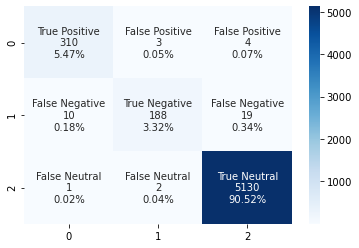

In [43]:
cf_matrix = confusion_matrix(y_test, preds)
group_names = ['True Positive', 'False Positive', 'False Positive',
               'False Negative', 'True Negative', 'False Negative',
               'False Neutral', 'False Neutral', 'True Neutral']

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

The precision and recall scores look a lot better and we can use them. But let's dig deeper

### Try another Method - Get Sentiments using Vadar Sentiment tool

In [7]:
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [90]:
def get_product_id(url):
    return str(url).split('/')[4]

In [89]:
product_reviews = df_[df_['asins']==product_id]['reviews_text']



['https:', '', 'www.amazon.com', 'product-reviews', 'B00QWO9P0O', '']


In [91]:
get_product_id(url)

'B00QWO9P0O'

In [12]:
review_scores

[-0.6908,
 0.3612,
 0.765,
 0.6124,
 0.6249,
 0.8625,
 0.4927,
 0.7003,
 0.4215,
 0.6124,
 0.501,
 0.5418,
 0.9001,
 0.4404,
 0.6249,
 0.9648,
 0.3612,
 0.8756,
 0.5927,
 0.1901,
 0.4404,
 0.8977,
 0.3612,
 -0.5255,
 0.3041,
 0.5927,
 0.9107,
 0.9421,
 0.7923,
 -0.2263,
 0.6249,
 0.1779,
 0.7964,
 0.7184,
 0.8074,
 0.6124,
 0.6124,
 0.4902,
 0.6369,
 -0.6124,
 0.1779,
 0.4215,
 0.1779,
 0.0498,
 0.7755,
 0.6369,
 0.2263,
 0.296,
 0.0,
 0.5326,
 0.7845,
 0.6249,
 0.8481,
 0.765,
 0.09,
 0.5719,
 0.6588,
 0.0,
 0.9458,
 0.893,
 0.3387,
 0.6249,
 0.8357,
 0.9989,
 0.0,
 0.5399,
 -0.1633,
 0.4215,
 0.927,
 0.8655,
 0.4577,
 0.6572,
 0.8481,
 0.9419,
 -0.5267,
 0.0,
 0.2732,
 0.0,
 0.6115,
 0.6597,
 0.0,
 0.8016,
 0.6124,
 0.7003,
 0.6901,
 0.836,
 0.8857,
 0.8176,
 0.8176,
 0.7345,
 0.6231,
 0.6249,
 0.1496,
 0.8713,
 0.7096,
 0.7906,
 0.6249,
 0.6249,
 0.9183,
 0.4404,
 0.9286,
 -0.5801,
 0.0,
 0.5264,
 0.2732,
 0.6249,
 0.34,
 0.5411,
 0.8885,
 0.6249,
 0.9904,
 0.75,
 0.6114,
 0.6124,
 

In [13]:
sentences[0]
vader_sentiment 

{'neg': 0.063, 'neu': 0.622, 'pos': 0.315, 'compound': 0.9621}

In [54]:
df[df['emotions']=='Satisfied']#head(30)

reviews_rating  \
2                   5   
5                   5   
7                   5   
12                  5   
15                  5   
...               ...   
28326               5   
28327               5   
28329               5   
28330               5   
28331               4   

                                                                                              reviews_text  \
2                                                 Well they are not Duracell but for the price i am happy.   
5      Bought a lot of batteries for Christmas and the AmazonBasics Cell have been good. I haven't noti...   
7      Well if you are looking for cheap non-rechargeable batteries that last quite a while then these ...   
12     Use it for my fish tank's light at night and works great, I love how you can easily switch it of...   
15     Thankful that I was able to find on Amazon for a great price and even better shipping. Arrived i...   
...                                                                                                    ...   
28326  Where do I begin...good clarity, I love the size and storage capacity! Very affordable, love wat...   
28327  I got 2 of these for my 8 yr old twins. My 11 yr old has one but this one is better. Perfect way...   
28329  Very nice for light internet browsing, keeping on top of email, viewing videos, and reading e bo...   
28330  This Tablet does absolutely everything I want! I can watch TV Shows or Movies, check my Mail, Fa...   
28331  At ninety dollars, the expectionations are low, but this is still a very good table, it's good f...   

        emotions  
2      Satisfied  
5      Satisfied  
7      Satisfied  
12     Satisfied  
15     Satisfied  
...          ...  
28326  Satisfied  
28327  Satisfied  
28329  Satisfied  
28330  Satisfied  
28331  Satisfied  

[14545 rows x 3 columns]

In [ ]:
#### Visualize most frequent words using word cloud

In [62]:
df_ = data.copy()
df_.head()

asins  reviews.rating  \
0  B00QWO9P0O,B00LH3DMUO               3   
1  B00QWO9P0O,B00LH3DMUO               4   
2  B00QWO9P0O,B00LH3DMUO               5   
3  B00QWO9P0O,B00LH3DMUO               5   
4  B00QWO9P0O,B00LH3DMUO               5   

                                                                                          reviews.text  
0  I order 3 of them and one of the item is bad quality. Is missing backup spring so I have to put ...  
1                                  Bulk is always the less expensive way to go for products like these  
2                                             Well they are not Duracell but for the price i am happy.  
3                                  Seem to work as well as name brand batteries at a much better price  
4                                            These batteries are very long lasting the price is great.

In [139]:
def clean_text_lemm(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [wn.lemmatize(word) for word in tokens if word not in stopwords]
    return text


In [2]:
product_ids

NameError: name 'product_ids' is not defined

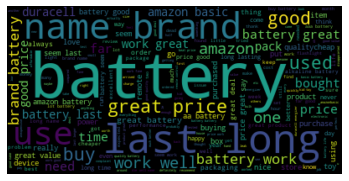

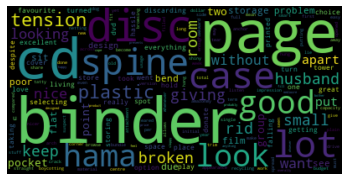

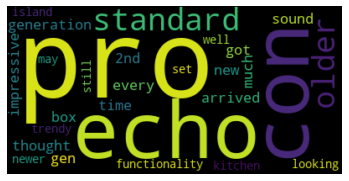

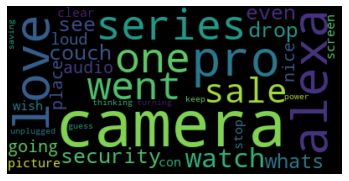

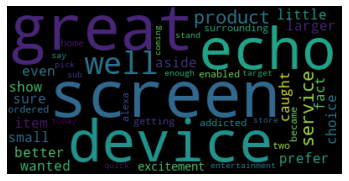

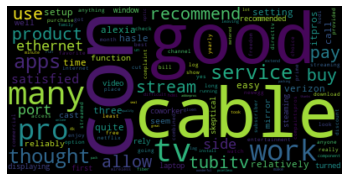

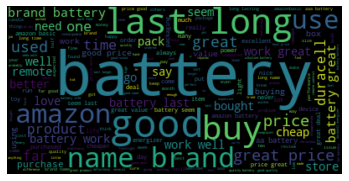

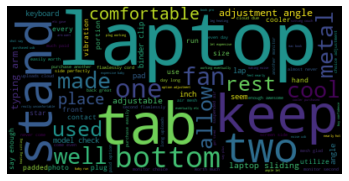

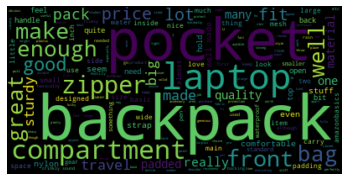

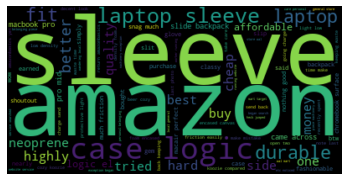

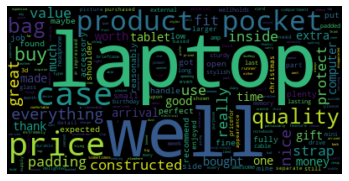

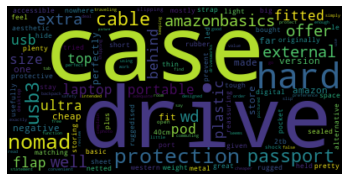

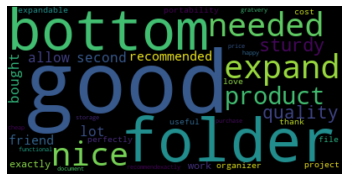

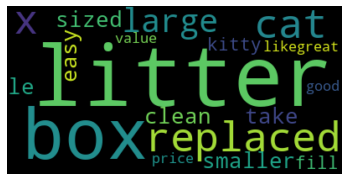

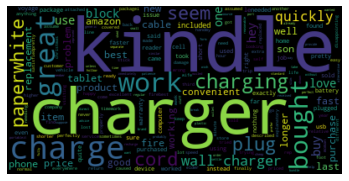

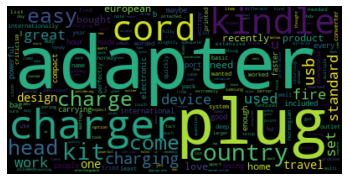

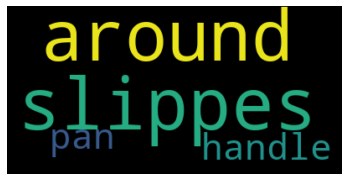

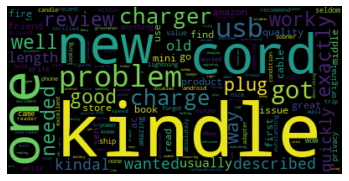

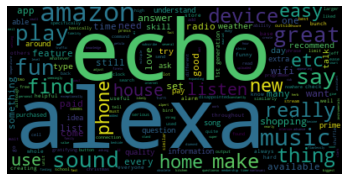

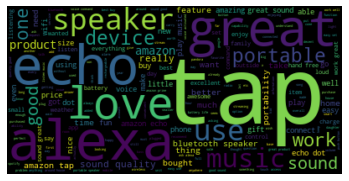

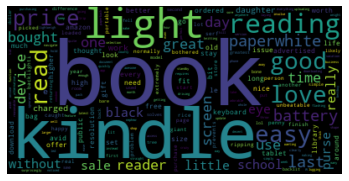

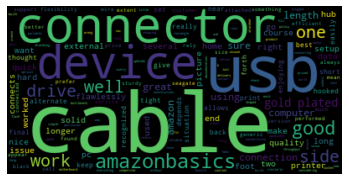

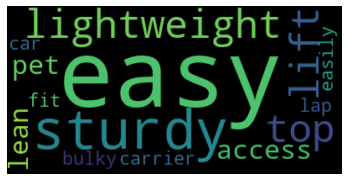

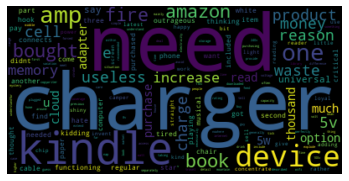

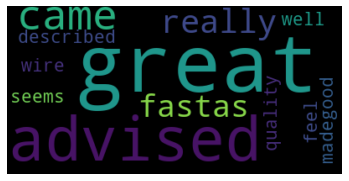

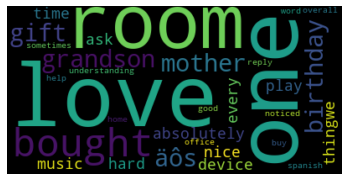

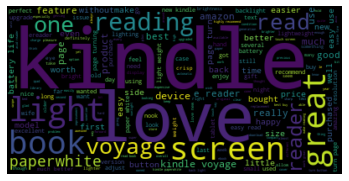

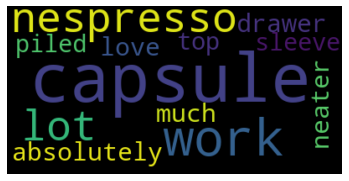

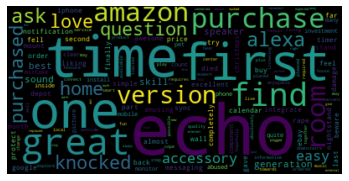

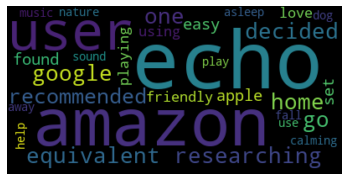

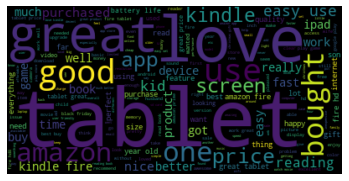

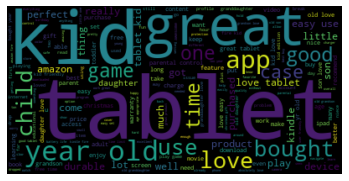

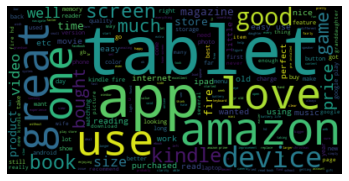

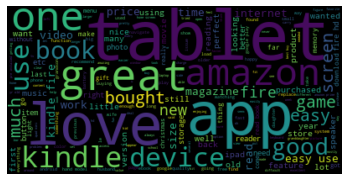

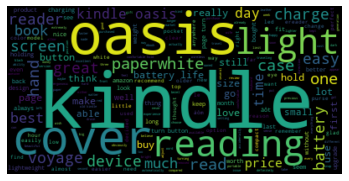

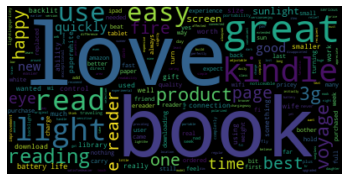

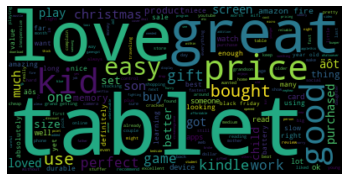

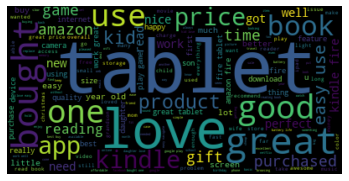

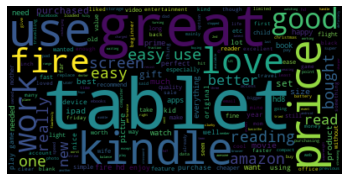

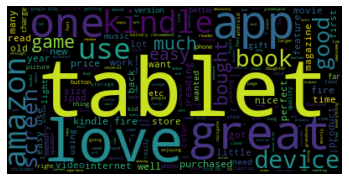

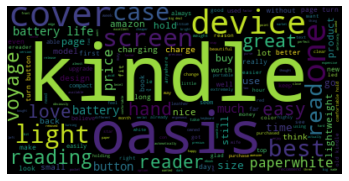

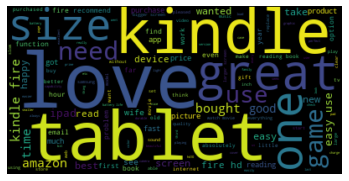

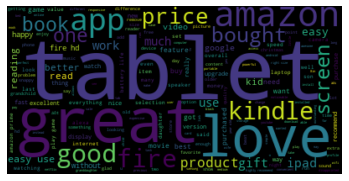

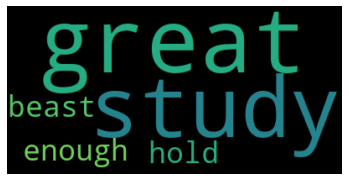

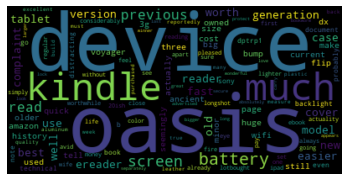

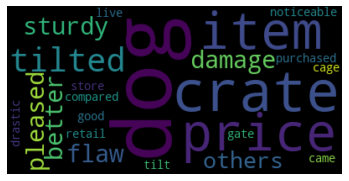

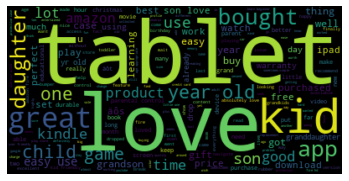

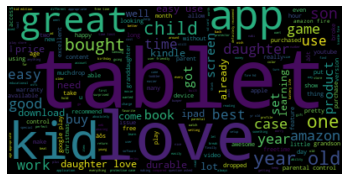

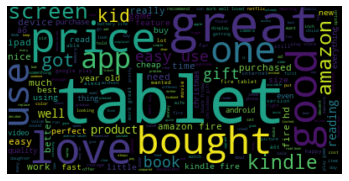

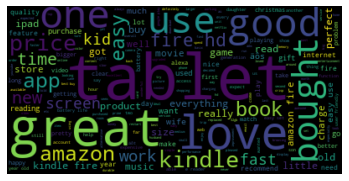

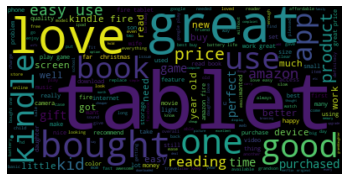

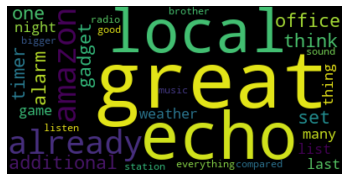

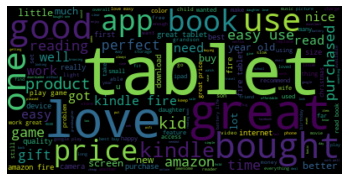

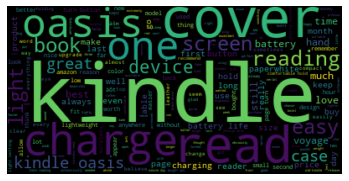

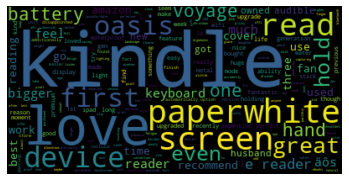

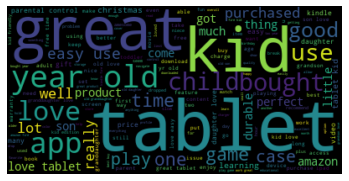

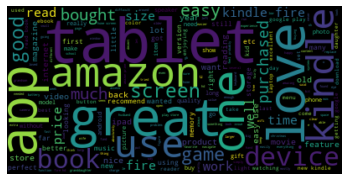

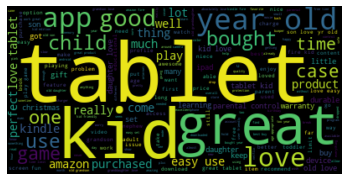

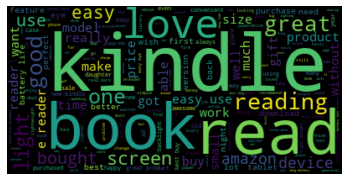

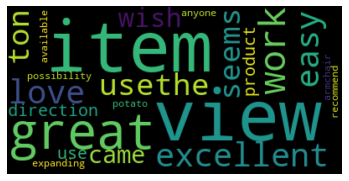

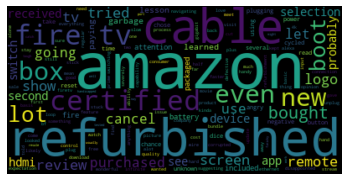

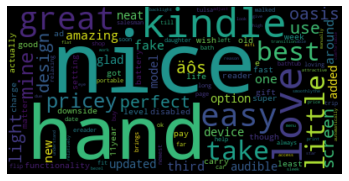

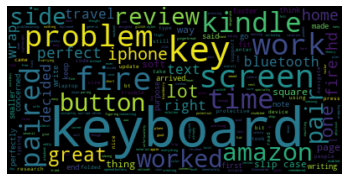

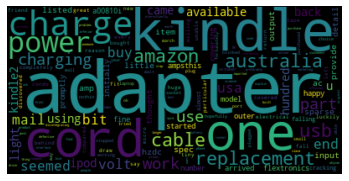

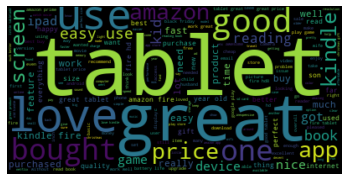

In [161]:
product_ids = df_['asins'].unique()
for product_id in product_ids:
    product_reviews = df_[df_['asins']==product_id]['reviews.text']
    product_reviews_str = product_reviews.astype("string")

    text_str = clean_text_lemm(product_reviews_str)
    word_cloud_text = " ".join([line for line in text_str])

    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(word_cloud_text)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()


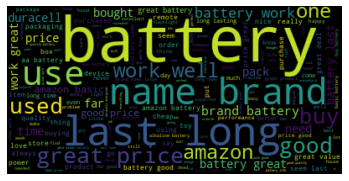

In [157]:
product_reviews = df_[df_['asins']=='B00QWO9P0O,B00LH3DMUO']['reviews.text']
product_reviews_str = product_reviews.astype("string")

text_str = clean_text_lemm(product_reviews_str)
word_cloud_text = " ".join([line for line in text_str])

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(word_cloud_text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [159]:
df_[df_['asins']=='B00QWO9P0O,B00LH3DMUO']

asins  reviews.rating  \
0     B00QWO9P0O,B00LH3DMUO               3   
1     B00QWO9P0O,B00LH3DMUO               4   
2     B00QWO9P0O,B00LH3DMUO               5   
3     B00QWO9P0O,B00LH3DMUO               5   
4     B00QWO9P0O,B00LH3DMUO               5   
...                     ...             ...   
8338  B00QWO9P0O,B00LH3DMUO               5   
8339  B00QWO9P0O,B00LH3DMUO               5   
8340  B00QWO9P0O,B00LH3DMUO               5   
8341  B00QWO9P0O,B00LH3DMUO               5   
8342  B00QWO9P0O,B00LH3DMUO               1   

                                                                                             reviews.text  
0     I order 3 of them and one of the item is bad quality. Is missing backup spring so I have to put ...  
1                                     Bulk is always the less expensive way to go for products like these  
2                                                Well they are not Duracell but for the price i am happy.  
3                                     Seem to work as well as name brand batteries at a much better price  
4                                               These batteries are very long lasting the price is great.  
...                                                                                                   ...  
8338                                                they are batteries. they work. who could ask for more  
8339                                                      They are batteries: not exciting but they work.  
8340                                                                           Yup. Batteries. They work.  
8341                                                                                       and they work.  
8342  Everyone read the 1 star reviews..the 5 star reviews must be people reviewing immediately. The 1...  

[8343 rows x 3 columns]

In [153]:
print(type(product_reviews))

<class 'pandas.core.series.Series'>


In [154]:
product_reviews_str.dtypes

StringDtype

In [151]:
print(type(text_str))

<class 'list'>


In [81]:
for review in product_reviews:
    sentiment = analyzer.sentiment_valence(review)
    #review_scores.append(sentiment['compound'])


TypeError: sentiment_valence() missing 4 required positional arguments: 'sentitext', 'item', 'i', and 'sentiments'

In [160]:
len(df_['asins'].unique())

65

In [80]:
dir(SentimentIntensityAnalyzer())

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_amplify_ep',
 '_amplify_qm',
 '_but_check',
 '_least_check',
 '_negation_check',
 '_punctuation_emphasis',
 '_sentiment_laden_idioms_check',
 '_sift_sentiment_scores',
 '_special_idioms_check',
 'emoji_full_filepath',
 'emojis',
 'lexicon',
 'lexicon_full_filepath',
 'make_emoji_dict',
 'make_lex_dict',
 'polarity_scores',
 'score_valence',
 'sentiment_valence']

<class 'pandas.core.series.Series'>


In [65]:

group_df = df_.groupby("asins")

#grouped_df.head()

grouped_lists = group_df["reviews.text"].apply(list)

grouped_lists = grouped_lists.reset_index()

grouped_lists.head(25)

asins  \
0   B0002LCUZK,B010CEC6MI,B01B25NN64   
1                         B001NIZB5M   
2                         B005OOKNP4   
3                         B006BGZJJ4   
4                         B006GWO7UA   
5                         B006LW0W5Y   
6                         B00BGIQS1A   
7              B00DIHVMEA,B00EZ1ZTV0   
8                         B00DUGZFWY   
9              B00EEBS9O0,B01CHQHIJK   
10             B00F5CKWBA,B00KPQCWAU   
11                        B00IOY8XWQ   
12                        B00IOYAM4I   
13             B00NH144GK,B00LA9H1E8   
14                        B00OP6SMCI   
15                        B00QAVNWSK   
16                        B00QAVO43C   
17                        B00QFQRELG   
18             B00QWO9P0O,B00LH3DMUO   
19  B00QWO9P0O,B01IB83NZG,B00MNV8E0C   
20                        B00REQKWGA   
21                        B00UH4D8G2   
22                        B00VINDBJK   
23                        B00VKTZFB4   
24                        B00WRDS8H0   

                                                                                           reviews.text  
0   [This folder also expands on the bottom. Will allow A LOT more than when the bottom does not exp...  
1   [Since the details for the items are a little sparse I thought I would provide the specs listed ...  
2   [Like a lot of reviewers here, I struggled to find the right Bluetooth keyboard to go with my Ki...  
3   [I wanted a new cord for my kindal and I wanted one like the one that came with my kindal. This ...  
4   [I travel internationally at least once a year and wanted an EASY way to charge my Kindle Fire H...  
5   [As advised. Came really fast, as described., great wires., Great feel and seems to be very well...  
6   [Is Amazon kidding me They want me to pay 19.99 for an item that is a critical part of the funct...  
7   [Great case to keep everything in its place! My husband love it!!!! Holds a lot of cds!, After d...  
8   [The larger one was bought for me as part of a Christmas gift...I enjoyed mine so much that I bo...  
9   [This is a very basic, functional backpack that does the job that it when designed for. Unlike o...  
10  [I have the Western Digital My Passport Ultra 2TB USB 3.0 Portable Drive 2.5 (laptop size) exter...  
11  [I bought this so i can save all of my books. It was a bit small at first but you get used to it...  
12  [best e reader to date. yes it's a bit pricey, but it reads like a real book., the back light na...  
13  [This is a good length cable for those that don't want tight connections because a cable is too ...  
14  [Sturdy, lightweight, tops lifts for easy access to pet , easy to lean and not bulky. Carrier wi...  
15  [I am very pleased with the dog crate. Very sturdy. No damage or flaws. Was better than some oth...  
16                                                        [It's great, study enough to hold the beast.]  
17  [It seems to work just like any other usb plug in charger., got this for my kindle 7 tablet . Do...  
18  [I order 3 of them and one of the item is bad quality. Is missing backup spring so I have to put...  
19  [Bulk is always the less expensive way to go for products like these, Doesn't seem to last as lo...  
20  [Kindles are an excellent device for all book lovers, I read a lot and have loved my kindle pape...  
21  [Certified garbage! Lesson learned about paying attention to reviews. Fire TV box and remote was...  
22  [Kindles are an excellent device for all book lovers, I read a lot and have loved my kindle pape...  
23  [I already have the Amazon Echo so this was just an additional one for my office. I think these ...  
24  [With an Income Tax Preparation practice I'm on my laptop 10 hours a day entering data. Using th...

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(classification, X_test, y_test, cmap='Blues')
plt.show()